## import library yang digunakan

In [19]:
import operator
from itertools import chain, combinations
from collections import defaultdict
import pandas as pd
import kagglehub
import os
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

## fungsi subsets, returnItemsWIthMinSupport dan joinSet

In [2]:
def subsets(arr):
    """Returns non empty subsets of arr"""
    return chain(*[combinations(arr, i + 1) for i, a in enumerate(arr)])

def returnItemsWithMinSupport(itemSet, transactionList, minSupport, freqSet):
    """calculates the support for items in the itemSet and returns a subset
       of the itemSet each of whose elements satisfies the minimum support"""
    _itemSet = set()
    localSet = defaultdict(int)

    for item in itemSet:
        for transaction in transactionList:
            if item.issubset(transaction):
                freqSet[item] += 1
                localSet[item] += 1
    
    for item, count in localSet.items():
        support = float(count) / len(transactionList)
        
        if support >= minSupport:
            _itemSet.add(item)
    
    return _itemSet

def joinSet(itemSet, length):
    """Join a set with itself and returns the n-element itemsets"""
    return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])

## fungsi getItemSetTransactionList dan runApriori

In [3]:

def getItemSetTransactionList(data_iterator):
    transactionList = list()
    itemSet = set()
    
    for record in data_iterator:
        transaction = frozenset(record)
        transactionList.append(transaction)
        
        for item in transaction:
            itemSet.add(frozenset([item])) # Generate 1-itemSets
    
    return itemSet, transactionList

def runApriori(data_iter, minSupport, minConfidence):
    """
    Run the apriori algorithm. data_iter is a record iterator
    Return both:
    - items (tuple, support)
    - rules (pretuple, posttuple, confidence)
    """
    itemSet, transactionList = getItemSetTransactionList(data_iter)

    freqSet = defaultdict(int)
    largeSet = dict()
    # Global dictionary which stores (key=n-itemSets, value=support)
    # which satisfy minSupport

    oneCset = returnItemsWithMinSupport(itemSet, transactionList, minSupport, freqSet)
    currentLset = oneCset
    k = 2
    while currentLset:
        largeSet[k - 1] = currentLset
        currentLset = joinSet(currentLset, k)
        currentCset = returnItemsWithMinSupport(currentLset, transactionList, minSupport, freqSet)
        currentLset = currentCset
        k += 1

    def getSupport(item):
        """ local function which Returns the support of an item """
        return float(freqSet[item]) / len(transactionList)

    toRetItems = []
    for key, value in largeSet.items():
        toRetItems.extend([(tuple(item), getSupport(item)) for item in value])

    toRetRules = []
    for key, value in list(largeSet.items())[1:]:
        for item in value:
            _subsets = map(frozenset, [x for x in subsets(item)])
            for element in _subsets:
                remain = item.difference(element)
                if len(remain) > 0:
                    confidence = getSupport(item) / getSupport(element)
                    if confidence >= minConfidence:
                        toRetRules.append(((tuple(element), tuple(remain)), confidence))
    return toRetItems, toRetRules

## fungsi printResult

In [4]:
def printResults(items, rules):
    print("------------ITEMS-----------------")
    for item, support in sorted(items, key=operator.itemgetter(1)):
        print(f"item: {item} , {support:.3f}")

    for item, support in sorted(items, key=operator.itemgetter(1)):
        print(f"item: {item} , {support:.3f}")

    print("\n------------RULES-----------------")
    for rule, confidence in sorted(rules, key=operator.itemgetter(1)):
        pre, post = rule
        print(f"Rule: {pre} ==> {post} , {confidence:.3f}")
    print("\n")

## fungsi dataFromFile

In [ ]:
def dataFromFile(fname):
    """ Function which reads from the file and yields a generator """
    file_iter  = open(fname, 'r')
    for line in file_iter:
        line = line.strip().rstrip(",")
        record = frozenset(line.split(","))
        yield record


## Mining Association Rules pada Dataset Penjualan

In [9]:
path = kagglehub.dataset_download("prepinstaprime/europe-bike-store-sales")

data = pd.read_csv(os.path.join(path, 'Sales.csv'))
df = pd.DataFrame(data.values)
df.columns = data.columns
minSupport = 0.15
minConfidence = 0.6

# ubah ke list of list
data_iter = df.astype(str).values.tolist()

items, rules = runApriori(data_iter, minSupport, minConfidence)
printResults(items, rules)

------------ITEMS-----------------
item: ('Accessories', 'F', 'Adults (35-64)') , 0.150
item: ('Accessories', '2', 'F') , 0.150
item: ('35', 'Accessories') , 0.151
item: ('Accessories', '2', 'M') , 0.152
item: ('Tires and Tubes', 'M') , 0.155
item: ('Accessories', 'Tires and Tubes', 'M') , 0.155
item: ('Accessories', 'M', 'Adults (35-64)') , 0.157
item: ('Youth (<25)',) , 0.158
item: ('Accessories', '13') , 0.164
item: ('Young Adults (25-34)', 'F') , 0.166
item: ('1', 'Bikes') , 0.166
item: ('Accessories', '1') , 0.167
item: ('F', 'United States') , 0.168
item: ('35',) , 0.168
item: ('1', 'F') , 0.168
item: ('1', 'Adults (35-64)') , 0.169
item: ('2', 'Adults (35-64)') , 0.175
item: ('Young Adults (25-34)', 'M') , 0.176
item: ('9',) , 0.177
item: ('2014', 'Accessories') , 0.177
item: ('Accessories', '2016') , 0.177
item: ('M', 'United States') , 0.179
item: ('1', 'M') , 0.180
item: ('2', 'F') , 0.180
item: ('13',) , 0.182
item: ('2', 'M') , 0.183
item: ('Tires and Tubes', '2') , 0.193
i

## type data dari kolom

In [11]:
df.dtypes

Date                object
Day                 object
Month               object
Year                object
Customer_Age        object
Age_Group           object
Customer_Gender     object
Country             object
State               object
Product_Category    object
Sub_Category        object
Product             object
Order_Quantity      object
Unit_Cost           object
Unit_Price          object
Profit              object
Cost                object
Revenue             object
dtype: object

## data processing

In [20]:


df['Profit'] = df['Profit'].astype(str).str.replace(',', '').astype(float)

df.dropna(subset=['Profit'], axis=0, inplace=True)
df = df[~df['Profit'].isin([0])]
df.head(5)

,Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue,Cluster
0,2013-11-26,26,November,2013,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590.0,360,950,1
1,2015-11-26,26,November,2015,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590.0,360,950,1
2,2014-03-23,23,March,2014,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,23,45,120,1366.0,1035,2401,0
3,2016-03-23,23,March,2016,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,20,45,120,1188.0,900,2088,0
4,2014-05-15,15,May,2014,47,Adults (35-64),F,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,4,45,120,238.0,180,418,1


## data transformation

In [17]:
import calendar

# Filter data untuk bulan > 6
df_bulan_gt_6 = df[df['Month'].apply(lambda x: str(x).isdigit() and int(x) > 6)]

# Jika kolom 'Month' berisi nama bulan, ubah ke angka
month_map = {month: idx for idx, month in enumerate(calendar.month_name) if month}
df_bulan_gt_6 = df[df['Month'].apply(lambda x: month_map.get(x, 0) > 6)]

# Pastikan kolom 'Cost' bertipe float sebelum groupby
df_bulan_gt_6['Cost'] = df_bulan_gt_6['Cost'].astype(float)
# Grup berdasarkan bulan dan ambil baris dengan biaya paling murah di setiap grup
result = df_bulan_gt_6.loc[df_bulan_gt_6.groupby('Month')['Cost'].idxmin()]

result.reset_index(drop=True, inplace=True)
result.head()

C:\Users\asus\AppData\Local\Temp\ipykernel_26468\686365993.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bulan_gt_6['Cost'] = df_bulan_gt_6['Cost'].astype(float)


,Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
0,2013-11-30,30,November,2013,24,Youth (<25),F,Canada,British Columbia,Accessories,Tires and Tubes,Patch Kit/8 Patches,1,1,2,1.0,1.0,2
1,2015-09-12,12,September,2015,48,Adults (35-64),F,Canada,British Columbia,Accessories,Tires and Tubes,Road Tire Tube,1,1,4,3.0,1.0,4


## clustering

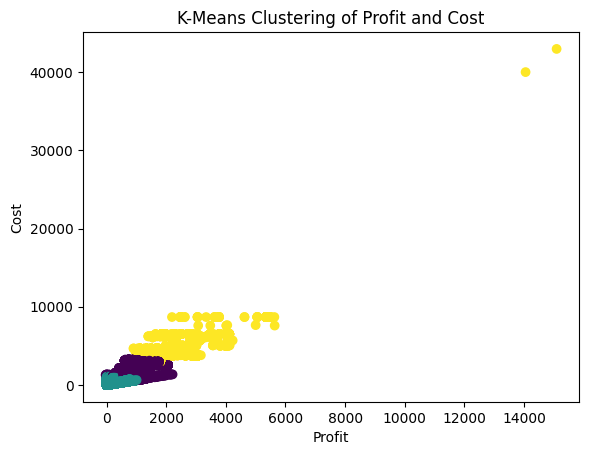

In [18]:
kmeans = KMeans(n_clusters=3)

# jumlah cluster
k = 3

# memilih kolom untuk clustering
X = df[['Profit', 'Cost']]


# melakukan clustering
kmeans = KMeans(n_clusters=k)
df['Cluster'] = kmeans.fit_predict(X)

plt.scatter(df['Profit'], df['Cost'], c=df['Cluster'])
plt.xlabel('Profit')
plt.ylabel('Cost')
plt.title('K-Means Clustering of Profit and Cost')
plt.show()
